In [16]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import requests
from selenium import webdriver
import re
import time
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy as sp

In [17]:

#Scraper using Selenium. Draws from NBA.com 
seasons = ['1996-97', '1997-98', '1999-00', '2000-01', '2001-02', '2002-03', '2003-04', '2004-05', '2005-06', '2006-07', '2007-08',
            '2008-09', '2009-10', '2010-11', '2011-12', '2012-13', '2013-14', '2014-15', '2015-16', '2016-17', '2017-18', '2018-19','2020-21']
def get_data(seasons_list):
    statistics = pd.DataFrame()
    for season in seasons_list:
        url = 'https://www.nba.com/stats/teams/traditional/?sort=W_PCT&dir=-1&Season='+season+'&SeasonType=Regular%20Season'
        driver = webdriver.Chrome(r"/Users/willbernstein/Desktop/chromedriver")
        driver.get(url)
        time.sleep(3)
        table = driver.find_element_by_class_name('nba-stat-table__overflow')
        remove_endline = table.text.split('\n')
        row_to_string = ' '.join(remove_endline)
        split_lines = re.sub(r'\s\d{1,2}\s([A-Z])', r'\n\1', row_to_string)
        separate_teams = split_lines.split('\n')
        table_list = []
        for row in separate_teams:
            split_stats = row.split()
            table_list.append(split_stats[-27:])
        df = pd.DataFrame.from_records(table_list[1:], columns = table_list[0])
        df.insert(0, 'SEASON', season)
        statistics = pd.concat([statistics, df], ignore_index = True)
        driver.close()
    return statistics




In [18]:
#Calls scraper, saves to CSV file, renames the coloumns 
statistics_df = get_data(seasons)
statistics_df
statistics_df.to_csv('nba_statistics_pergame.csv', index=False)

stats_df = pd.read_csv('nba_statistics_pergame.csv')
stats_df.rename(columns = {'WIN%' : 'WIN_PERCENT', 'FG%': 'FG_PERCENT', '3PM': 'THREE_PM', '3PA': 'THREE_PA', '3P%': 'THREE_P_PERCENT', 'FT%': 'FT_PERCENT', '+/-' : 'PLUS_MINUS'}, inplace=True)

stats_df

<ipython-input-17-1b42227d82d3>:7: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(r"/Users/willbernstein/Desktop/chromedriver")
<ipython-input-17-1b42227d82d3>:10: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  table = driver.find_element_by_class_name('nba-stat-table__overflow')


,SEASON,TEAM,GP,W,L,WIN_PERCENT,MIN,PTS,FGM,FGA,...,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PLUS_MINUS
0,1996-97,Bulls,82,69,13,0.841,48.1,103.1,40.0,84.4,...,30.0,45.1,26.1,13.5,8.7,4.0,3.5,19.7,0.2,10.8
1,1996-97,Jazz,82,64,18,0.780,48.4,103.1,38.2,75.8,...,29.4,40.2,26.8,15.4,9.1,5.1,4.5,24.1,0.2,8.8
2,1996-97,Heat,82,61,21,0.744,48.3,94.8,34.4,76.0,...,29.3,41.0,21.2,15.9,7.9,5.4,4.8,23.4,0.3,5.5
3,1996-97,Rockets,82,57,25,0.695,48.4,100.6,37.0,79.1,...,31.3,42.6,24.5,16.6,8.4,4.2,4.5,19.6,0.2,4.5
4,1996-97,Knicks,82,57,25,0.695,48.4,95.4,35.1,75.9,...,30.7,42.5,22.1,17.8,7.7,4.6,3.6,24.8,0.2,3.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
678,2020-21,Cavaliers,72,22,50,0.306,48.4,103.8,38.6,85.8,...,32.3,42.8,23.8,15.5,7.8,4.5,5.9,18.2,20.2,-8.4
679,2020-21,Thunder,72,22,50,0.306,48.2,105.0,38.8,88.0,...,35.7,45.6,22.1,16.1,7.0,4.4,5.3,18.1,18.6,-10.6
680,2020-21,Magic,72,21,51,0.292,48.1,104.0,38.3,89.2,...,35.1,45.4,21.8,12.8,6.9,4.4,5.3,17.2,18.6,-9.3
681,2020-21,Pistons,72,20,52,0.278,48.4,106.6,38.7,85.6,...,33.1,42.7,24.2,14.9,7.4,5.2,5.8,20.5,20.4,-4.5


In [25]:
#look at each variables correlation to Wins to eliminate all with high correlation 
corr = stats_df.corr()
abs(corr).sort_values(by = 'W', ascending = False)['W']

W                  1.000000
WIN_PERCENT        0.987630
PLUS_MINUS         0.957403
L                  0.954820
FG_PERCENT         0.584550
BLKA               0.473050
THREE_P_PERCENT    0.460656
TOV                0.340699
AST                0.339096
PTS                0.309735
DREB               0.288497
FGM                0.261892
REB                0.216052
BLK                0.204147
FTM                0.189650
THREE_PM           0.163664
PF                 0.152819
GP                 0.150030
FT_PERCENT         0.142905
OREB               0.141912
STL                0.141734
FTA                0.138828
FGA                0.112984
THREE_PA           0.097688
PFD                0.016555
MIN                0.013961
Name: W, dtype: float64

(26.5, -0.5)

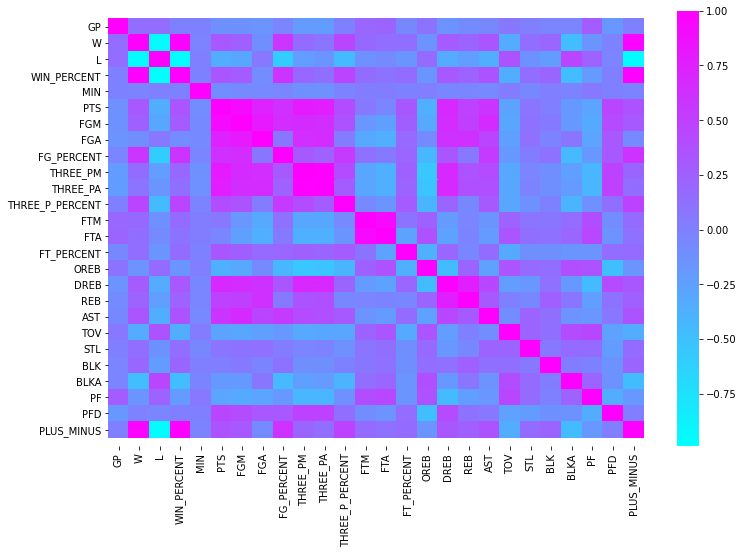

In [23]:
#Heat map of all variable's and their correlation with eachother to 
#help adjust for multi-colinearity 
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(stats_df.corr(), ax=ax, cmap='cool')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

In [19]:
#normalize the data that is not associated with 'wins'
y = 'W'
x = ['PTS', 'FGM', 'FGA', 'FG_PERCENT', 'THREE_PM', 'THREE_PA', 'THREE_P_PERCENT', 'FTM', 'FTA', 'FT_PERCENT', 'OREB', 'DREB', 'REB', 'AST', 'TOV', 'STL', 'BLK', 'BLKA', 'PF']
for col in stats_df[x]:
    stats_df[col] = (stats_df[col] - stats_df[col].mean())/stats_df[col].std()
stats_df

,SEASON,TEAM,GP,W,L,WIN_PERCENT,MIN,PTS,FGM,FGA,...,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PLUS_MINUS
0,1996-97,Bulls,82,69,13,0.841,48.1,0.518913,1.222776,0.578015,...,-0.521692,1.334849,1.970791,-0.885618,1.160327,-1.112880,-1.997073,-0.803449,0.2,10.8
1,1996-97,Jazz,82,64,18,0.780,48.4,0.518913,0.414951,-1.748224,...,-0.793965,-1.113813,2.308316,0.680354,1.608702,0.216595,-0.591901,1.655084,0.2,8.8
2,1996-97,Heat,82,61,21,0.744,48.3,-0.793862,-1.290456,-1.694126,...,-0.839344,-0.714032,-0.391885,1.092452,0.263576,0.579179,-0.170349,1.263954,0.3,5.5
3,1996-97,Rockets,82,57,25,0.695,48.4,0.123499,-0.123598,-0.855597,...,0.068235,0.085532,1.199305,1.669389,0.824045,-0.871157,-0.591901,-0.859325,0.2,4.5
4,1996-97,Knicks,82,57,25,0.695,48.4,-0.698962,-0.976302,-1.721175,...,-0.204039,0.035559,0.042076,2.658423,0.039389,-0.387712,-1.856556,2.046214,0.2,3.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
678,2020-21,Cavaliers,72,22,50,0.306,48.4,0.629629,0.594468,0.956706,...,0.522024,0.185477,0.861780,0.762773,0.151483,-0.508573,1.375341,-1.641585,20.2,-8.4
679,2020-21,Thunder,72,22,50,0.306,48.2,0.819428,0.684226,1.551790,...,2.064908,1.584712,0.042076,1.257291,-0.745268,-0.629434,0.532237,-1.697461,18.6,-10.6
680,2020-21,Magic,72,21,51,0.292,48.1,0.661262,0.459830,1.876382,...,1.792634,1.484767,-0.102578,-1.462555,-0.857362,-0.629434,0.532237,-2.200343,18.6,-9.3
681,2020-21,Pistons,72,20,52,0.278,48.4,1.072493,0.639347,0.902607,...,0.885056,0.135504,1.054651,0.268256,-0.296893,0.337456,1.234824,-0.356443,20.4,-4.5


In [20]:
#a series of eliminating predictors until we have a sound model 
variables = '+'.join(stats_df[x])
formula = y + '~' + variables
model = ols(formula=formula, data=stats_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      W   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     159.3
Date:                Tue, 07 Dec 2021   Prob (F-statistic):          3.79e-232
Time:                        15:50:23   Log-Likelihood:                -2113.1
No. Observations:                 683   AIC:                             4266.
Df Residuals:                     663   BIC:                             4357.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          40.4275      0.207    194.995      0.000      40.020      40.835
PTS                15.2191     18.008      0.845      0.398     -20.140      50.578
FGM                -9.7953     12.476     -0.785      0.433     -34.292      14.701
FGA               -11.7767      5.201     -2.264      0.024     -21.990      -1.563
FG_PERCENT          3.3472      4.058      0.825      0.410      -4.622      11.316
THREE_PM           -8.3463      8.417     -0.992      0.322     -24.874       8.182
THREE_PA            4.3317      3.931      1.102      0.271      -3.388      12.051
THREE_P_PERCENT     2.3396      0.619      3.782      0.000       1.125       3.554
FTM                -6.0382      6.832     -0.884      0.377     -19.452       7.376
FTA                 1.4937      4.627      0.323      0.747      -7.592      10.579
FT_PERCENT          1.7235      1.703      1.012      0.312      -1.621       5.068
OREB                9.9919      6.129      1.630      0.104      -2.042      22.026
DREB               13.0121      9.298      1.399      0.162      -5.246      31.270
REB                -3.3794      8.429     -0.401      0.689     -19.930      13.171
AST                 1.6603      0.306      5.426      0.000       1.059       2.261
TOV                -5.9452      0.282    -21.085      0.000      -6.499      -5.392
STL                 4.7144      0.245     19.221      0.000       4.233       5.196
BLK                 0.3282      0.228      1.441      0.150      -0.119       0.775
BLKA               -1.4602      0.276     -5.293      0.000      -2.002      -0.919
PF                  1.0668      0.281      3.798      0.000       0.515       1.618
==============================================================================
Omnibus:                        0.330   Durbin-Watson:                   1.535
Prob(Omnibus):                  0.848   Jarque-Bera (JB):                0.251
Skew:                          -0.043   Prob(JB):                        0.882
Kurtosis:                       3.039   Cond. No.                         290.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [26]:
x_2 = ['PTS',  'FGA', 'FG_PERCENT', 'THREE_PM', 'THREE_PA', 'THREE_P_PERCENT', 'FTM', 'FT_PERCENT', 'OREB', 'DREB', 'AST', 'TOV', 'STL', 'BLK', 'BLKA', 'PF']
variables = '+'.join(x_2)
formula = y + '~' + variables
model = ols(formula=formula, data=stats_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      W   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     189.6
Date:                Tue, 07 Dec 2021   Prob (F-statistic):          2.48e-235
Time:                        15:56:24   Log-Likelihood:                -2113.6
No. Observations:                 683   AIC:                             4261.
Df Residuals:                     666   BIC:                             4338.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          40.4275      0.207    195.290      0.000      40.021      40.834
PTS                 3.5684      9.434      0.378      0.705     -14.955      22.092
FGA               -12.9587      5.029     -2.577      0.010     -22.834      -3.084
FG_PERCENT          2.3959      3.915      0.612      0.541      -5.292      10.083
THREE_PM           -3.9830      6.239     -0.638      0.523     -16.233       8.267
THREE_PA            4.7266      3.862      1.224      0.221      -2.857      12.310
THREE_P_PERCENT     2.3962      0.607      3.945      0.000       1.204       3.589
FTM                -1.0021      2.903     -0.345      0.730      -6.701       4.697
FT_PERCENT          1.1785      0.261      4.508      0.000       0.665       1.692
OREB                7.5502      0.363     20.781      0.000       6.837       8.264
DREB                9.2851      0.384     24.187      0.000       8.531      10.039
AST                 1.6712      0.305      5.488      0.000       1.073       2.269
TOV                -5.9501      0.281    -21.190      0.000      -6.501      -5.399
STL                 4.7113      0.244     19.321      0.000       4.232       5.190
BLK                 0.3302      0.227      1.452      0.147      -0.116       0.777
BLKA               -1.4776      0.275     -5.379      0.000      -2.017      -0.938
PF                  1.0742      0.280      3.837      0.000       0.525       1.624
==============================================================================
Omnibus:                        0.232   Durbin-Watson:                   1.529
Prob(Omnibus):                  0.890   Jarque-Bera (JB):                0.181
Skew:                          -0.039   Prob(JB):                        0.914
Kurtosis:                       3.020   Cond. No.                         148.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [28]:
x_3 = ['PTS',  'FGA',  'THREE_P_PERCENT', 'FTM', 'OREB', 'DREB', 'AST', 'TOV', 'STL', 'BLK', 'BLKA', 'PF']
variables = '+'.join(x_2)
formula = y + '~' + variables
model = ols(formula=formula, data=stats_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      W   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     189.6
Date:                Tue, 07 Dec 2021   Prob (F-statistic):          2.48e-235
Time:                        15:57:23   Log-Likelihood:                -2113.6
No. Observations:                 683   AIC:                             4261.
Df Residuals:                     666   BIC:                             4338.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          40.4275      0.207    195.290      0.000      40.021      40.834
PTS                 3.5684      9.434      0.378      0.705     -14.955      22.092
FGA               -12.9587      5.029     -2.577      0.010     -22.834      -3.084
FG_PERCENT          2.3959      3.915      0.612      0.541      -5.292      10.083
THREE_PM           -3.9830      6.239     -0.638      0.523     -16.233       8.267
THREE_PA            4.7266      3.862      1.224      0.221      -2.857      12.310
THREE_P_PERCENT     2.3962      0.607      3.945      0.000       1.204       3.589
FTM                -1.0021      2.903     -0.345      0.730      -6.701       4.697
FT_PERCENT          1.1785      0.261      4.508      0.000       0.665       1.692
OREB                7.5502      0.363     20.781      0.000       6.837       8.264
DREB                9.2851      0.384     24.187      0.000       8.531      10.039
AST                 1.6712      0.305      5.488      0.000       1.073       2.269
TOV                -5.9501      0.281    -21.190      0.000      -6.501      -5.399
STL                 4.7113      0.244     19.321      0.000       4.232       5.190
BLK                 0.3302      0.227      1.452      0.147      -0.116       0.777
BLKA               -1.4776      0.275     -5.379      0.000      -2.017      -0.938
PF                  1.0742      0.280      3.837      0.000       0.525       1.624
==============================================================================
Omnibus:                        0.232   Durbin-Watson:                   1.529
Prob(Omnibus):                  0.890   Jarque-Bera (JB):                0.181
Skew:                          -0.039   Prob(JB):                        0.914
Kurtosis:                       3.020   Cond. No.                         148.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [29]:
new_xcols2 = ['PTS','THREE_P_PERCENT', 'FTM', 'OREB', 'DREB', 'AST', 'TOV', 'STL', 'BLK', 'BLKA', 'PF']
variables = '+'.join(new_xcols2)
formula = y + '~' + variables
model = ols(formula=formula, data=stats_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      W   R-squared:                       0.650
Model:                            OLS   Adj. R-squared:                  0.645
Method:                 Least Squares   F-statistic:                     113.5
Date:                Tue, 07 Dec 2021   Prob (F-statistic):          4.94e-145
Time:                        15:57:27   Log-Likelihood:                -2340.3
No. Observations:                 683   AIC:                             4705.
Df Residuals:                     671   BIC:                             4759.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          40.4275      0.287    140.655      0.000      39.863      40.992
PTS                -5.9377      0.541    -10.981      0.000      -6.999      -4.876
THREE_P_PERCENT     4.9816      0.360     13.851      0.000       4.275       5.688
FTM                 5.4595      0.350     15.602      0.000       4.772       6.147
OREB                2.8217      0.376      7.496      0.000       2.083       3.561
DREB                6.4117      0.504     12.714      0.000       5.421       7.402
AST                 2.7540      0.393      7.012      0.000       1.983       3.525
TOV                -3.7991      0.364    -10.446      0.000      -4.513      -3.085
STL                 4.0976      0.335     12.221      0.000       3.439       4.756
BLK                 0.9990      0.310      3.221      0.001       0.390       1.608
BLKA               -4.5209      0.342    -13.225      0.000      -5.192      -3.850
PF                 -0.6799      0.375     -1.811      0.071      -1.417       0.057
==============================================================================
Omnibus:                        0.331   Durbin-Watson:                   1.352
Prob(Omnibus):                  0.847   Jarque-Bera (JB):                0.204
Skew:                          -0.011   Prob(JB):                        0.903
Kurtosis:                       3.082   Cond. No.                         4.68
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [9]:
#final variables
formula

'W~PTS+THREE_P_PERCENT+FTM+OREB+DREB+AST+TOV+STL+BLK+BLKA+PF'

In [35]:
#scrape current years data 
seasons_x = ['2021-22']
def get_data(seasons_list):
    statistics = pd.DataFrame()
    for season in seasons_list:
        url = 'https://www.nba.com/stats/teams/traditional/?sort=W_PCT&dir=-1&Season='+season+'&SeasonType=Regular%20Season'
        driver = webdriver.Chrome(r"/Users/willbernstein/Desktop/chromedriver")
        driver.get(url)
        time.sleep(3)
        table = driver.find_element_by_class_name('nba-stat-table__overflow')
        remove_endline = table.text.split('\n')
        row_to_string = ' '.join(remove_endline)
        split_lines = re.sub(r'\s\d{1,2}\s([A-Z])', r'\n\1', row_to_string)
        separate_teams = split_lines.split('\n')
        table_list = []
        for row in separate_teams:
            split_stats = row.split()
            table_list.append(split_stats[-27:])
        df = pd.DataFrame.from_records(table_list[1:], columns = table_list[0])
        df.insert(0, 'SEASON', season)
        statistics = pd.concat([statistics, df], ignore_index = True)
        driver.close()
    return statistics
statistics_df_test = get_data(seasons_x)
statistics_df_test
statistics_df_test.to_csv('nba_statistics_pergame_current.csv', index=False)

stats_df_test = pd.read_csv('nba_statistics_pergame_current.csv')
stats_df_test.rename(columns = {'WIN%' : 'WIN_PERCENT', 'FG%': 'FG_PERCENT', '3PM': 'THREE_PM', '3PA': 'THREE_PA', '3P%': 'THREE_P_PERCENT', 'FT%': 'FT_PERCENT', '+/-' : 'PLUS_MINUS'}, inplace=True)

stats_df_test


<ipython-input-35-12015a4fad4c>:7: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(r"/Users/willbernstein/Desktop/chromedriver")
<ipython-input-35-12015a4fad4c>:10: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  table = driver.find_element_by_class_name('nba-stat-table__overflow')


,SEASON,TEAM,GP,W,L,WIN_PERCENT,MIN,PTS,FGM,FGA,...,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PLUS_MINUS
0,2021-22,Warriors,24,20,4,0.833,48.2,113.6,41.4,87.0,...,37.2,47.1,29.0,16.2,10.0,4.7,3.7,19.8,18.0,13.0
1,2021-22,Suns,24,20,4,0.833,48.0,111.4,42.2,88.2,...,36.1,45.0,26.1,13.8,9.0,4.0,3.8,18.8,19.4,6.4
2,2021-22,Nets,23,16,7,0.696,48.0,109.5,39.9,85.8,...,36.4,44.7,25.5,13.9,6.8,5.3,4.9,19.3,20.0,3.7
3,2021-22,Jazz,23,16,7,0.696,48.0,114.0,40.7,85.7,...,36.3,46.3,22.3,15.1,7.4,5.4,4.1,19.2,19.5,9.2
4,2021-22,Bulls,25,17,8,0.680,48.0,109.6,41.0,87.3,...,34.8,43.8,23.4,13.2,8.0,4.8,5.6,18.6,17.8,4.7
5,2021-22,Bucks,25,16,9,0.640,48.2,110.5,40.2,88.9,...,37.6,48.0,23.0,14.4,7.2,4.5,4.8,17.6,18.8,4.2
6,2021-22,Grizzlies,24,14,10,0.583,48.4,111.0,42.0,93.0,...,34.8,47.8,25.5,14.0,9.8,6.3,6.1,18.8,18.2,0.1
7,2021-22,Heat,25,14,11,0.560,48.4,107.0,39.1,85.3,...,33.9,44.2,24.5,14.7,7.6,2.8,4.9,20.5,19.9,2.5
8,2021-22,Wizards,25,14,11,0.560,48.6,105.5,39.4,85.3,...,36.2,45.2,23.6,13.8,6.3,5.2,4.5,18.7,19.8,-0.9
9,2021-22,Celtics,24,13,11,0.542,49.3,108.9,39.5,89.0,...,36.1,46.5,22.7,13.6,7.4,5.7,4.7,19.0,20.0,2.4


In [37]:
for col in stats_df_test[x]:
    stats_df_test[col] = (stats_df_test[col] - stats_df_test[col].mean())/stats_df_test[col].std()
stats_df_test

,SEASON,TEAM,GP,W,L,WIN_PERCENT,MIN,PTS,FGM,FGA,...,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PLUS_MINUS
0,2021-22,Warriors,24,20,4,0.833,48.2,1.470501,0.889480,-0.573729,...,1.575514,1.464591,2.695709,1.474327,2.330641,-0.279516,-1.631781,0.537233,18.0,13.0
1,2021-22,Suns,24,20,4,0.833,48.0,0.941313,1.332375,-0.056079,...,0.835941,-0.078373,1.237210,-0.365388,1.271259,-1.155610,-1.499475,-0.208924,19.4,6.4
2,2021-22,Nets,23,16,7,0.696,48.0,0.484287,0.059053,-1.091380,...,1.037643,-0.298796,0.935451,-0.288733,-1.059382,0.471422,-0.044102,0.164155,20.0,3.7
3,2021-22,Jazz,23,16,7,0.696,48.0,1.566717,0.501947,-1.134517,...,0.970409,0.876795,-0.673927,0.631124,-0.423753,0.596578,-1.102555,0.089539,19.5,9.2
4,2021-22,Bulls,25,17,8,0.680,48.0,0.508341,0.668033,-0.444317,...,-0.038099,-0.960066,-0.120703,-0.825317,0.211876,-0.154359,0.882044,-0.358155,17.8,4.7
5,2021-22,Bucks,25,16,9,0.640,48.2,0.724827,0.225138,0.245884,...,1.844450,2.125861,-0.321876,0.094541,-0.635629,-0.529828,-0.176409,-1.104312,18.8,4.2
6,2021-22,Grizzlies,24,14,10,0.583,48.4,0.845097,1.221651,2.014523,...,-0.038099,1.978912,0.935451,-0.212078,2.118765,1.722985,1.543577,-0.208924,18.2,0.1
7,2021-22,Heat,25,14,11,0.560,48.4,-0.117063,-0.383842,-1.307067,...,-0.643204,-0.666168,0.432520,0.324505,-0.211876,-2.657486,-0.044102,1.059543,19.9,2.5
8,2021-22,Wizards,25,14,11,0.560,48.6,-0.477873,-0.217757,-1.307067,...,0.903175,0.068576,-0.020117,-0.365388,-1.589074,0.346266,-0.573328,-0.283540,19.8,-0.9
9,2021-22,Celtics,24,13,11,0.542,49.3,0.339963,-0.162395,0.289022,...,0.835941,1.023744,-0.472755,-0.518697,-0.423753,0.972047,-0.308715,-0.059693,20.0,2.4


In [38]:

#W = 40.4275-5.9377(pts) +4.9816(3%)+5.4595(ftm)+2.8217(OREB)+6.4117(DREB)+2.7540(ast)-3.7991(TOV)+4.0974(STL)+0.9990(blk)-4.5209(BLKA)-0.6799(PF)
#plug current data into model 
wins={}
for i in range(30):
    wins[stats_df_test.iloc[i]['TEAM']] = 40.4275 -5.9377*stats_df_test.iloc[i]['PTS']+4.9816*stats_df_test.iloc[i]['THREE_P_PERCENT']+5.4595*stats_df_test.iloc[i]['FTM']+2.8217*stats_df_test.iloc[i]['OREB']+6.4117*stats_df_test.iloc[i]['DREB']+2.7540*stats_df_test.iloc[i]['AST']-3.7991*stats_df_test.iloc[i]['TOV']+4.0974*stats_df_test.iloc[i]['STL']+stats_df_test.iloc[i]['BLK']-4.5209*stats_df_test.iloc[i]['BLKA']-0.6799*stats_df_test.iloc[i]['PF']
for key in wins.keys():
    print(key+ ' Predicted Wins: '+str(wins[key]))


Warriors Predicted Wins: 65.5539343636671
Suns Predicted Wins: 59.35429635867693
Nets Predicted Wins: 51.700015625122354
Jazz Predicted Wins: 46.72787701875905
Bulls Predicted Wins: 43.45797145183515
Bucks Predicted Wins: 49.69330000457609
Grizzlies Predicted Wins: 44.45725171053499
Heat Predicted Wins: 38.70485483087895
Wizards Predicted Wins: 42.9907894372093
Celtics Predicted Wins: 51.163785617712556
76ers Predicted Wins: 47.668955526698056
Hornets Predicted Wins: 43.027816141534935
Hawks Predicted Wins: 52.949146599718006
Cavaliers Predicted Wins: 39.71972081250628
Clippers Predicted Wins: 42.3182561814586
Mavericks Predicted Wins: 33.91005987512149
Lakers Predicted Wins: 51.06278861282902
Nuggets Predicted Wins: 24.306442867965966
Knicks Predicted Wins: 44.68718263849781
Timberwolves Predicted Wins: 27.112117455301053
Raptors Predicted Wins: 30.800468970071755
Blazers Predicted Wins: 39.82916428962247
Kings Predicted Wins: 31.071717522280718
Pacers Predicted Wins: 32.4280567150115